# Testbed to compare the results of the parameter search
This bunches of code tests the differences between the window based on time and the window based on transfers. Once the link is defined, is possible to modify the parameters independently for different window selection and later to apply the EWMA to a set of the data. Later a plot is made to compare the results obtained by the to different window selection approach. 


In [ ]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [39]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

def get_link_data(src, dst, act, date='2017-08-01', span=1):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = date  # yyyy-mm-dd
    DELTA = span
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = []
    for i in range(-1, DELTA+1):
        index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                          + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
    #indexes = ','.join(index_list)
    indexes = 'fts_*'
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=span)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "src" : src }},
                    {"term" : { "dst" : dst }},
                    {"term" : { "activity" : act }},
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    #print('Reading took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    print('%d records retrieved for link %s --> %s (%s).' % (len(data), src, dst, act))
    return data
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    queue_limit_time = 7*24*60*60  # 7 days in sec.
    for i in range(1,span):
        s.append(min((s[i-1] + i*b[i-1]),queue_limit_time))
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

def calculate_ewma(window=12, beta=0.1):
    preds = []
    for t in data.index:
        history = cut[cut.index < t]
        history = history[history.index > history.index.max() - dt.timedelta(hours=windows)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s,b = hwsoewma_forcast(s0, b0, beta, 1)
            preds.append(max(s[0],-1))
        else:
            preds.append(-1)
    return preds


def make_prediction_time(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        history = history[history.index > history.index.max() - dt.timedelta(minutes=window)]
        if len(history) > 0:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(subcut))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

def make_prediction_active_mean(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        active = cut1[cut1.index < current]
        active = active[active.ENDED.values > current.value/(10**9)]
        if len(active) > 0:
            s1 = np.mean(current.value/(10**9) - active.SUBMITTED.values)
            preds.extend([s1]*fspan)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

def make_prediction_active_max(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        active = cut1[cut1.index < current]
        active = active[active.ENDED.values > current.value/(10**9)]
        if len(active) > 0:
            s1 = np.max(current.value/(10**9) - active.SUBMITTED.values)
            preds.extend([s1]*fspan)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

def make_prediction_transfer(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        s = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        s = s[s.index > current]
        fspan = len(s)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        #history = history.set_index(pd.to_datetime(history.ENDED.values,unit='s'))
        #history = history.sort_index()
        history = history.loc[history.index[-window:]]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(s))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(s))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

In [61]:
def compare_ewma(src, dst, act, days):
    # parameters for time based window
    # window in minutes
    window_1 = 100
    # recalculate every x minutes
    every_1 = 5
    # the bigger the beta, the faster EWMA will react
    beta_1 = 0.0000
    # parameters for transfer based window
    # number of transfers in the window
    window_2 = 100
    # recalculate every x minutes
    every_2 = 5
    beta_2 = 0.0000

    data = get_link_data(src, dst, act,'2017-08-01', days)
    x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
    x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
    x3,y3,y_real3 = make_prediction_active_mean(data, 60*24*7, every_1, beta_1)
    x4,y4,y_real4 = make_prediction_active_max(data, 60*24*7, every_1, beta_1)

    print(np.mean(y_real1/60),np.std(y_real1/60))
    plt.title('%s --> %s (%s)'% (src,dst,act))
    plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
    plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
             label='(A)time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)),alpha=0.5)
    plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
             label='(B)tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)),alpha=0.5)
    plt.plot(pd.to_datetime(x3,unit='s'),y3/60,'.',
             label='(C)active window (mean) MAE:%.2f min R²:%.3f'%(mae(y_real3,y3)/60,r2(y_real3,y3)),alpha=0.5)
    plt.plot(pd.to_datetime(x4,unit='s'),y4/60,'.',
             label='(D)active window (max) MAE:%.2f min R²:%.3f'%(mae(y_real4,y4)/60,r2(y_real4,y4)),alpha=0.5)

    #plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time',alpha=0.5)
    #plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel('Submitted timestamp')
    plt.ylabel('Queue time in minutes')
    fig = plt.gcf()
    fig.set_size_inches(17, 8)
    plt.legend()
    plt.grid()
    plt.show()

    plt.hist(y_real1/60 - y1/60, label='real - predA in minutes',bins=100, alpha=0.5)
    plt.hist(y_real2/60 - y2/60, label='real - predB in minutes',bins=100, alpha=0.5)
    plt.hist(y_real3/60 - y3/60, label='real - predC in minutes',bins=100, alpha=0.5)
    plt.hist(y_real4/60 - y4/60, label='real - predD in minutes',bins=100, alpha=0.5)
    plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel('real - pred in minutes')
    fig = plt.gcf()
    fig.set_size_inches(17, 8)
    plt.legend()
    plt.grid()
    plt.show()

90110 records retrieved for link MWT2 --> BNL-ATLAS (Data Consolidation).
1303.90022917 2538.61017953


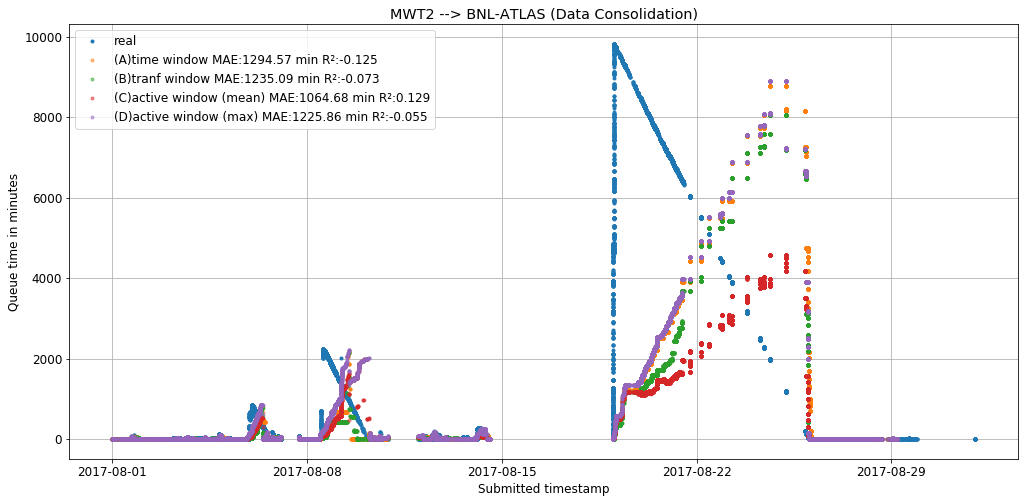

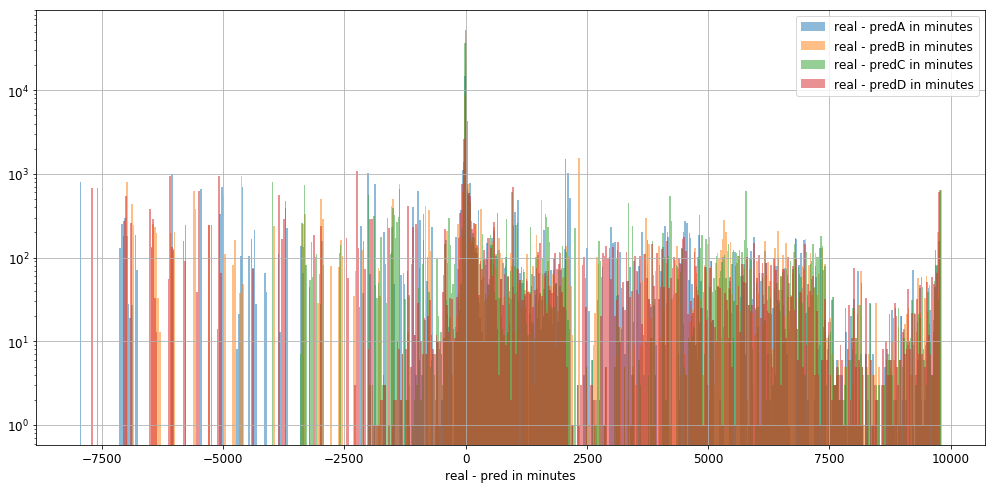

21939 records retrieved for link MWT2 --> BNL-ATLAS (Production Input).
152.199840368 480.090553808


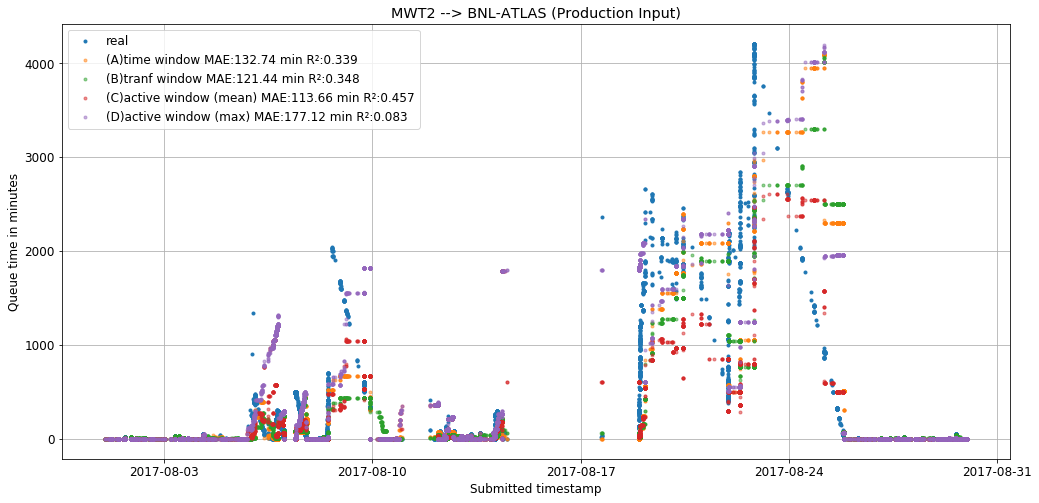

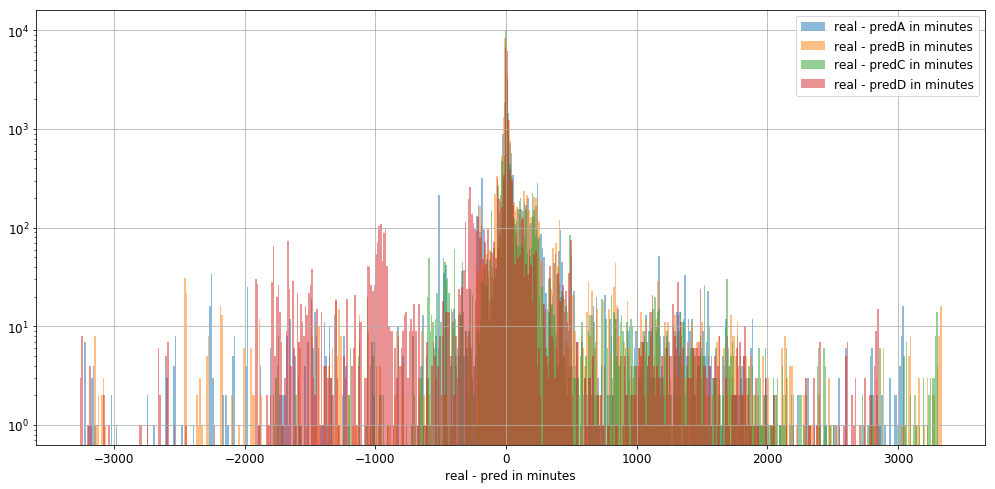

8036 records retrieved for link MWT2 --> BNL-ATLAS (Production Output).
155.883426721 442.673560988


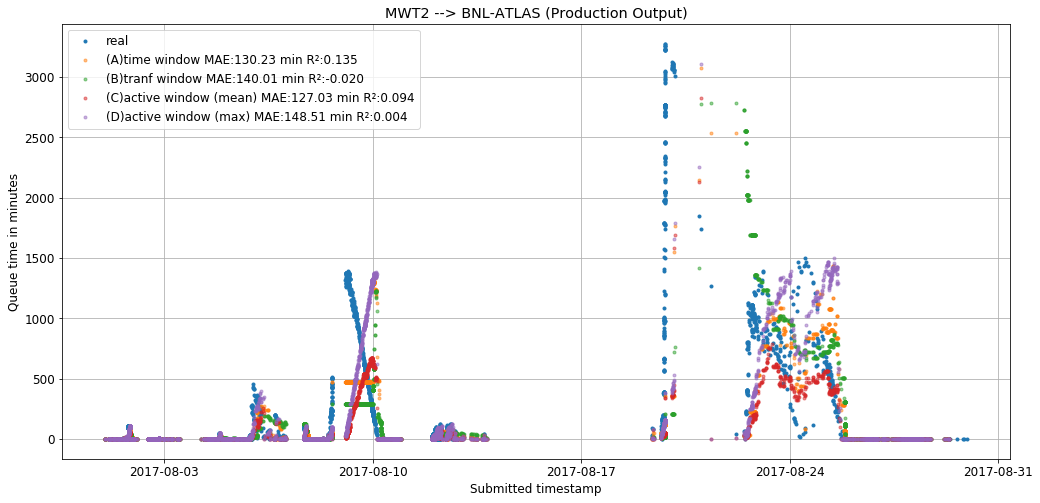

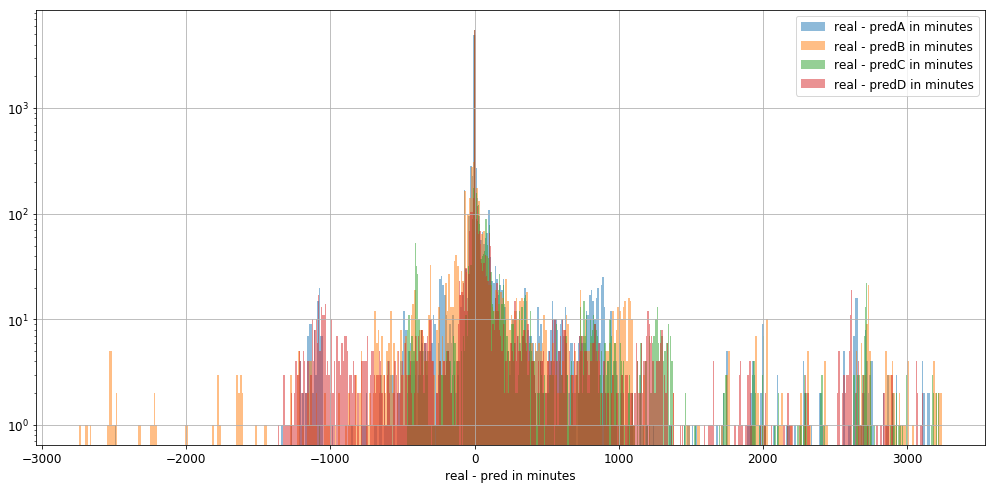

42088 records retrieved for link MWT2 --> BNL-ATLAS (User Subscriptions).
1076.37074715 2194.06208659


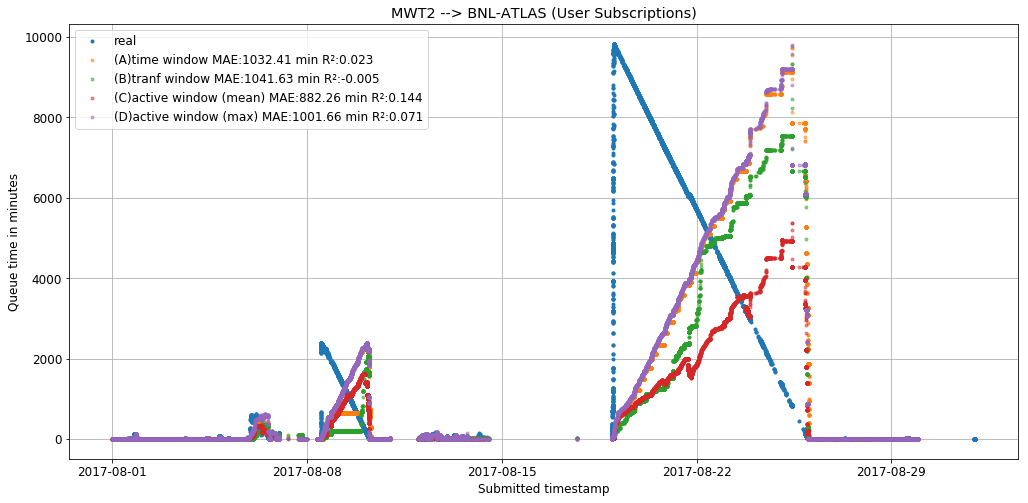

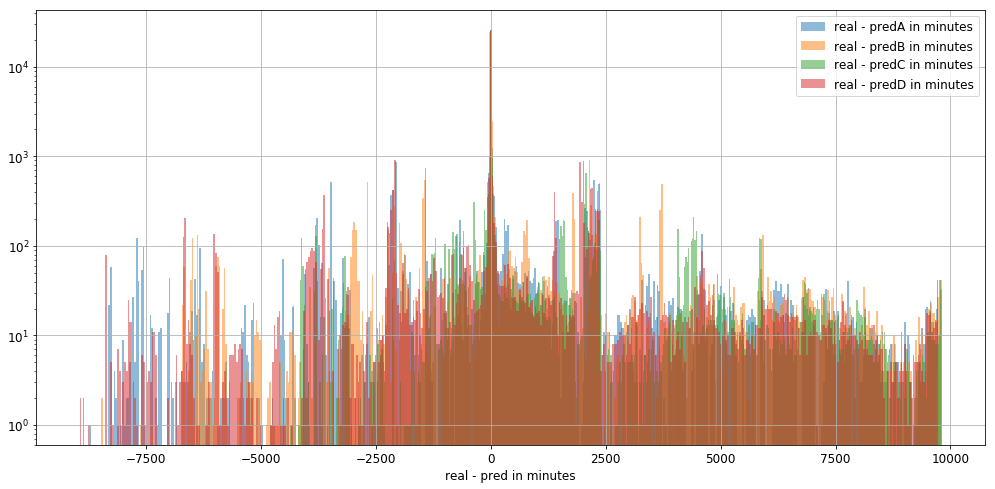

In [60]:
for act in ['Data Consolidation',
            #'Functional Test',
            #'Express', 
            'Production Input',
            'Production Output',
            #'Staging',
            #'T0 Export',
            'User Subscriptions'
           ]:
    compare_ewma('MWT2','BNL-ATLAS', act, 31)

49666 records retrieved for link MWT2 --> BNL-ATLAS (Data Consolidation).
20.2641027454 92.6874494742


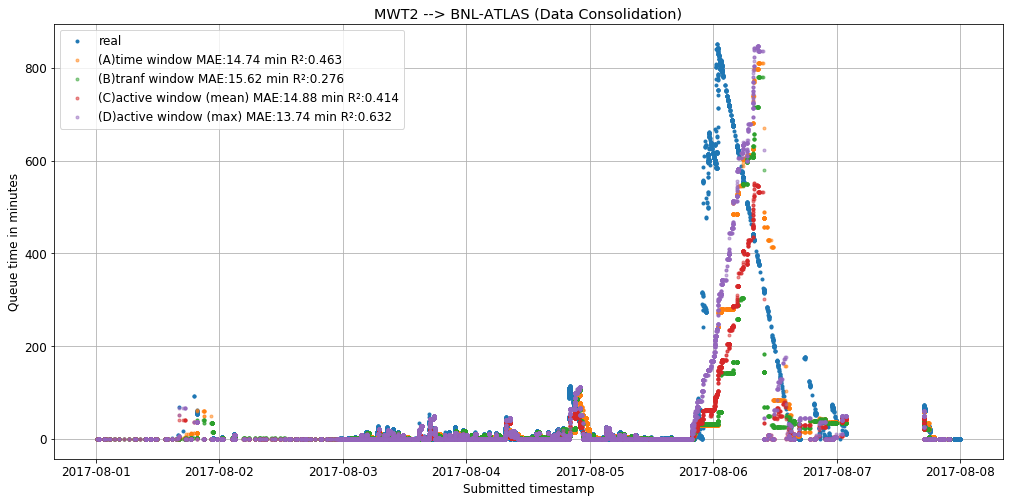

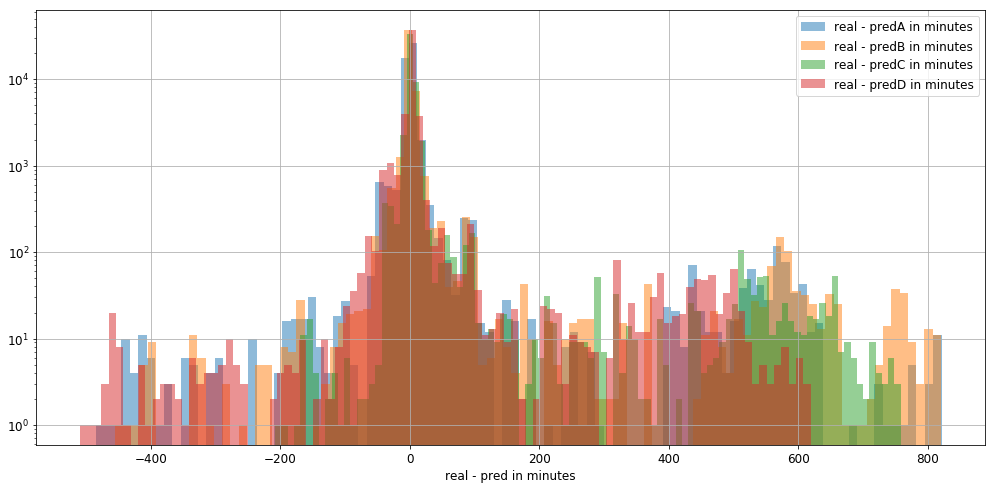

9337 records retrieved for link MWT2 --> BNL-ATLAS (Production Input).
77.5458539028 118.25434714


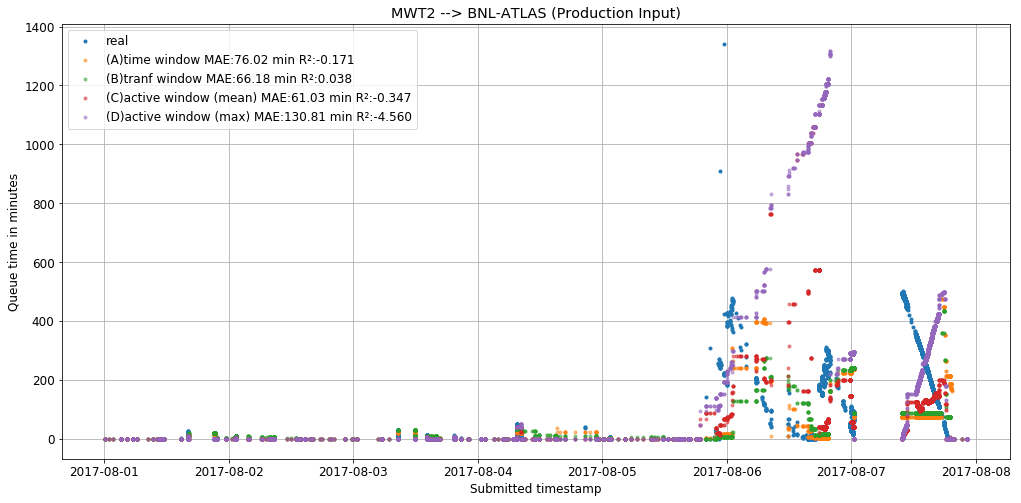

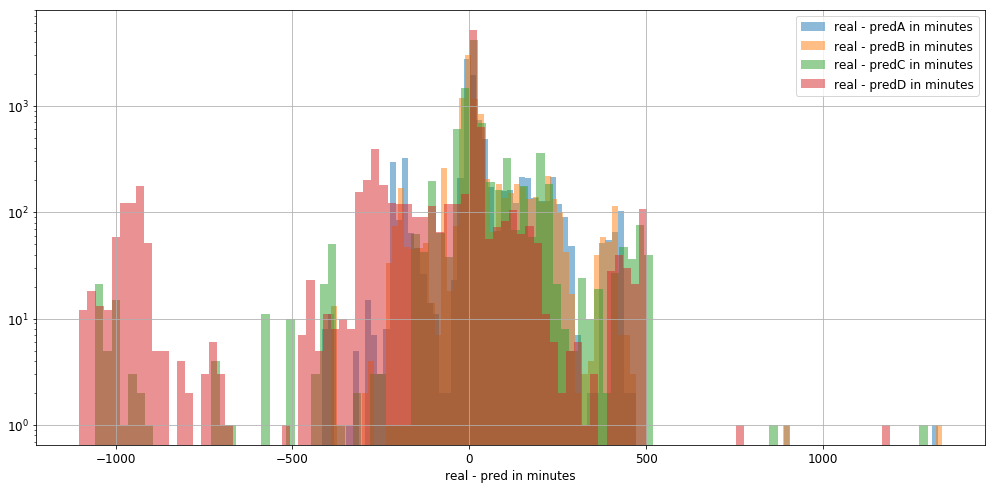

4219 records retrieved for link MWT2 --> BNL-ATLAS (Production Output).
11.1975258873 41.122490165


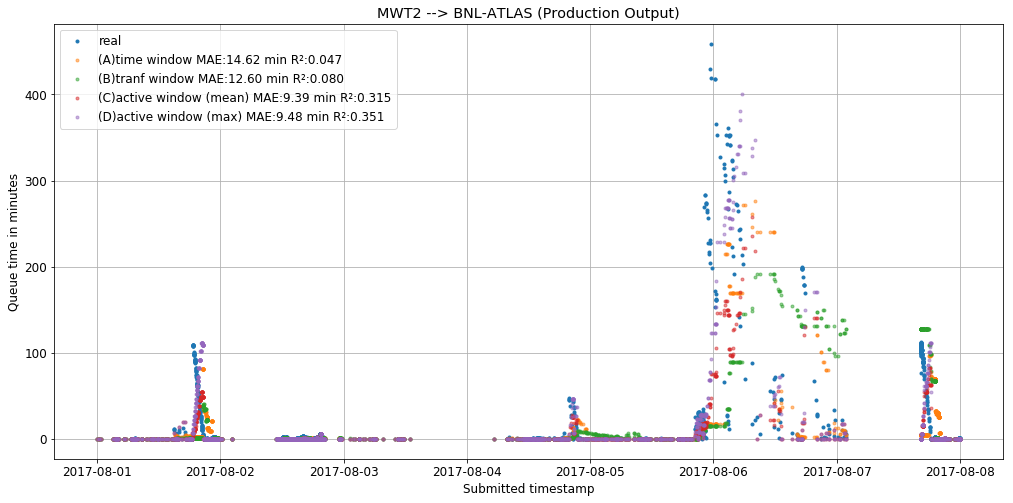

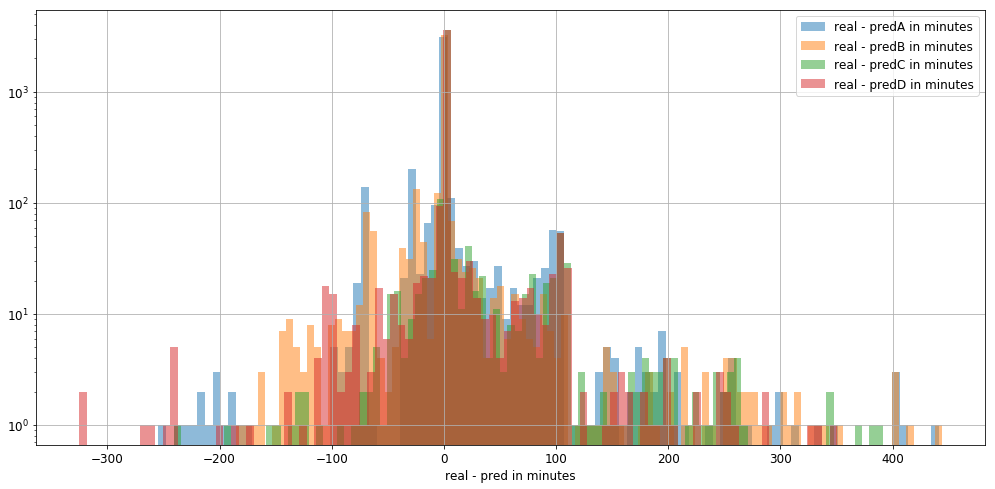

17913 records retrieved for link MWT2 --> BNL-ATLAS (User Subscriptions).
11.016447675 52.1938788741


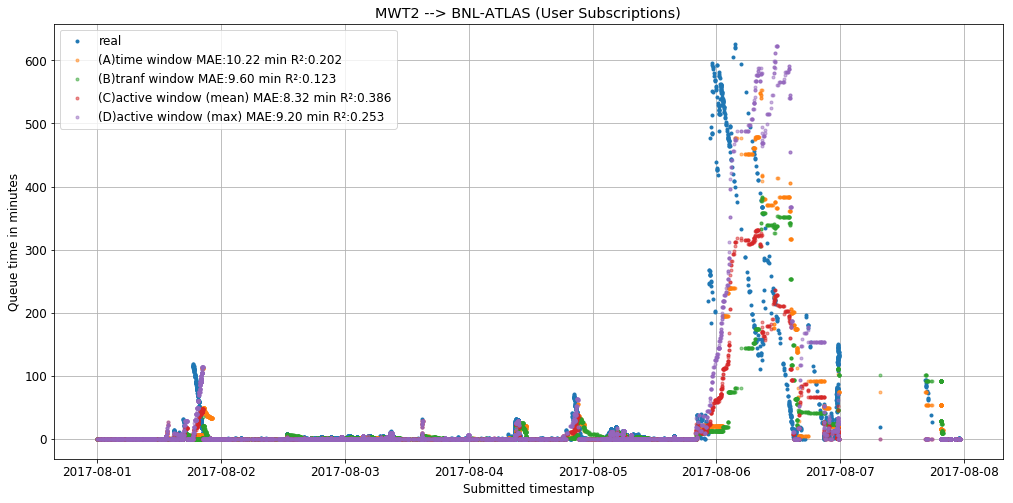

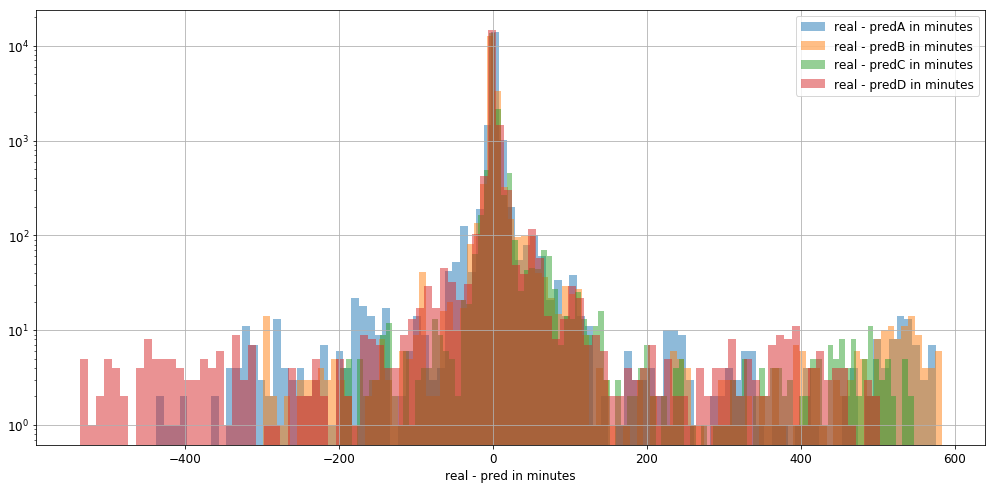

In [62]:
for act in ['Data Consolidation',
            #'Functional Test',
            #'Express', 
            'Production Input',
            'Production Output',
            #'Staging',
            #'T0 Export',
            'User Subscriptions'
           ]:
    compare_ewma('MWT2','BNL-ATLAS', act, 7)

98983 records retrieved for link CERN-PROD --> BNL-ATLAS (Data Consolidation).
2218.48745245 2997.32560212


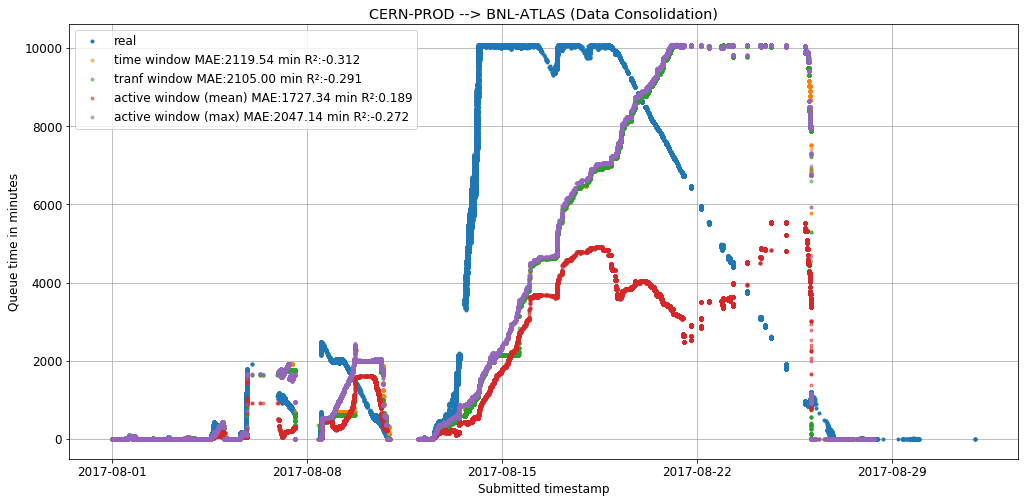

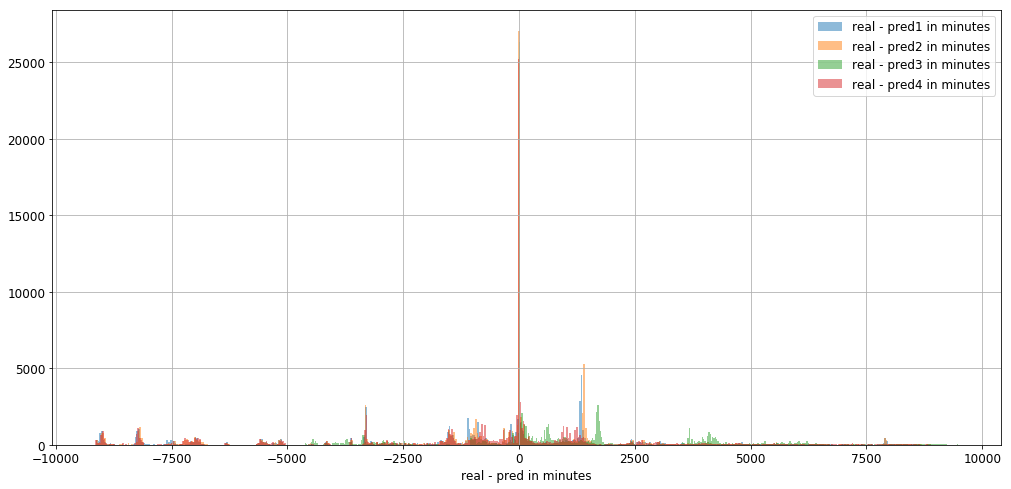

40410 records retrieved for link CERN-PROD --> BNL-ATLAS (Functional Test).
75.8026061177 140.142668687


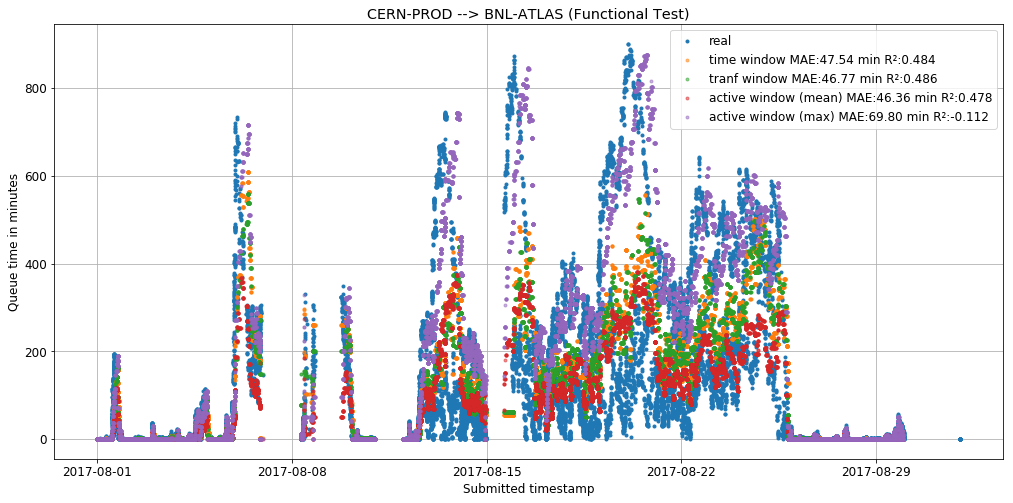

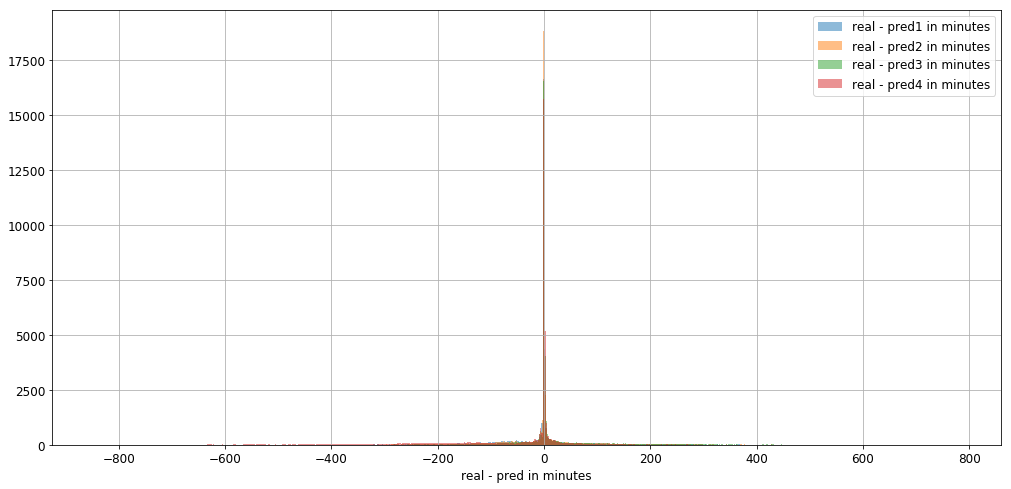

114484 records retrieved for link CERN-PROD --> BNL-ATLAS (Express).
483.089901308 878.228392735


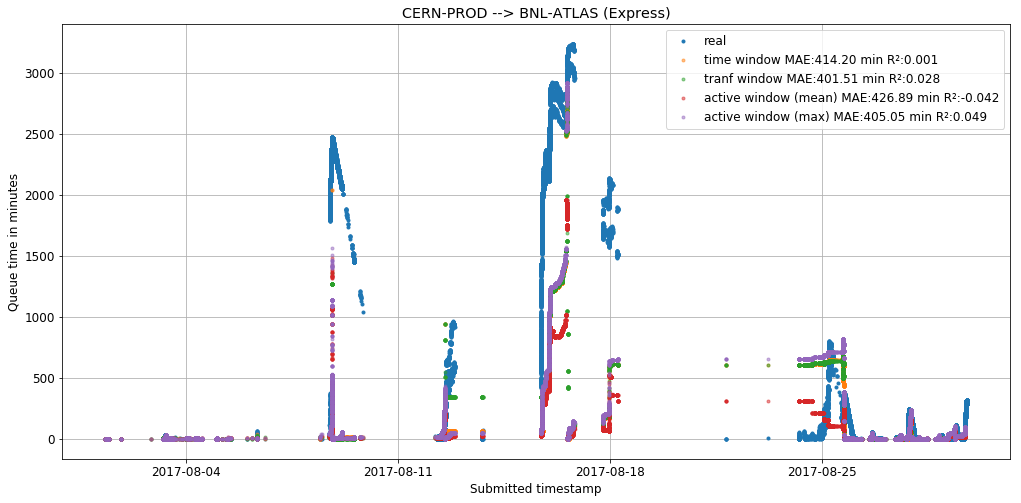

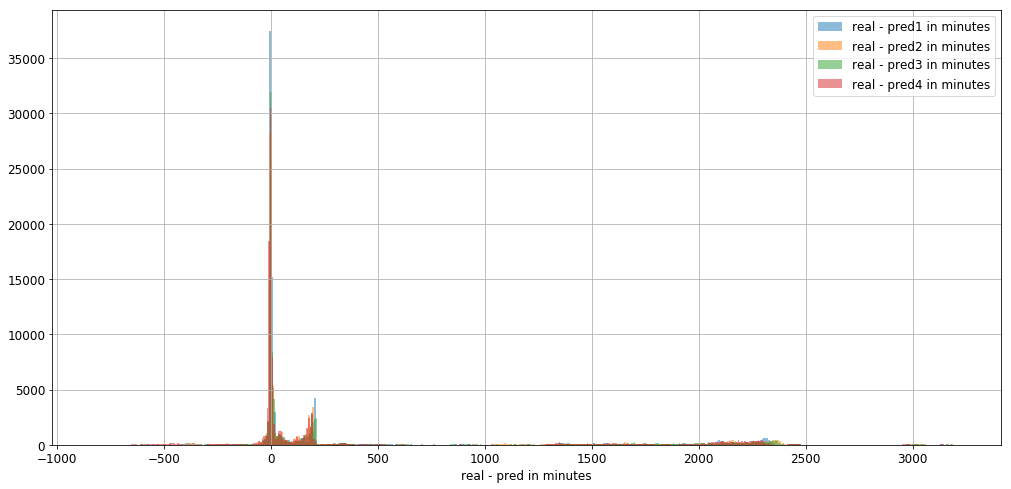

41423 records retrieved for link CERN-PROD --> BNL-ATLAS (Production Input).
876.000276863 848.21329845


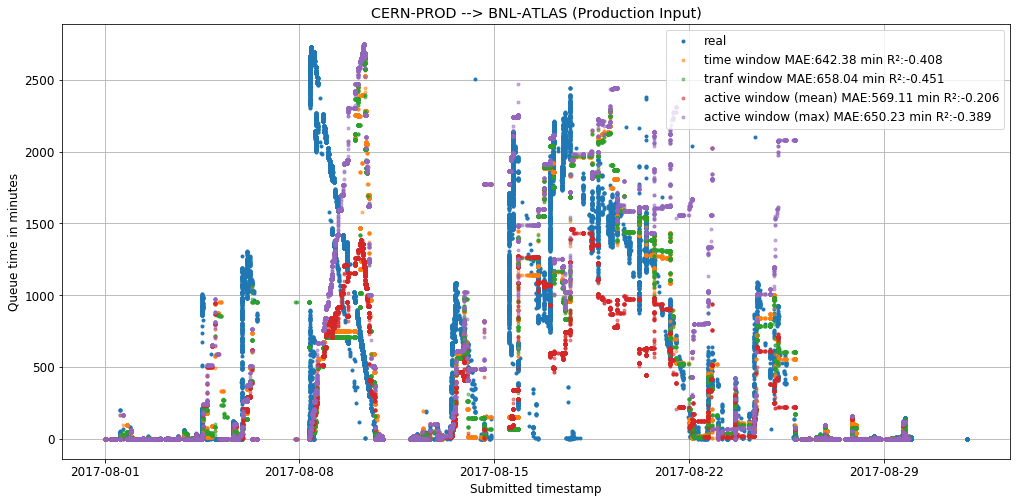

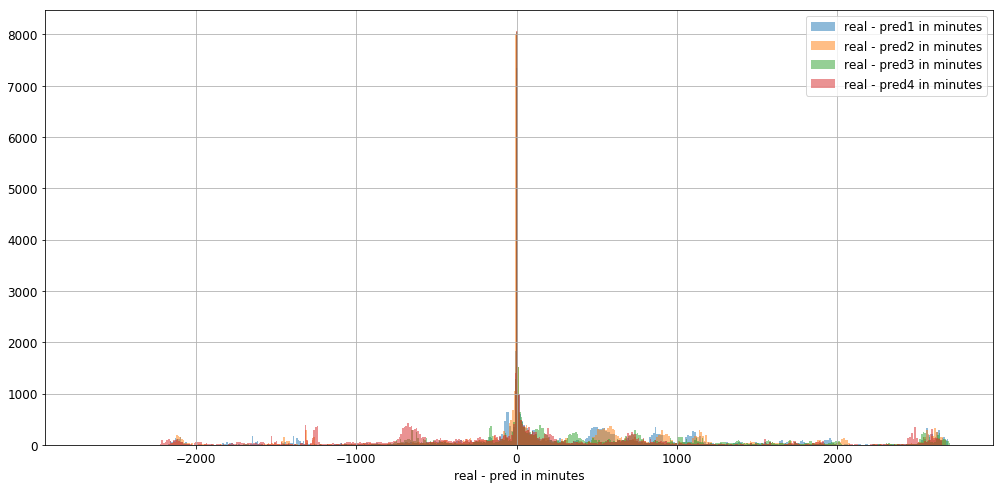

15728 records retrieved for link CERN-PROD --> BNL-ATLAS (Production Output).
219.038996176 419.682246258


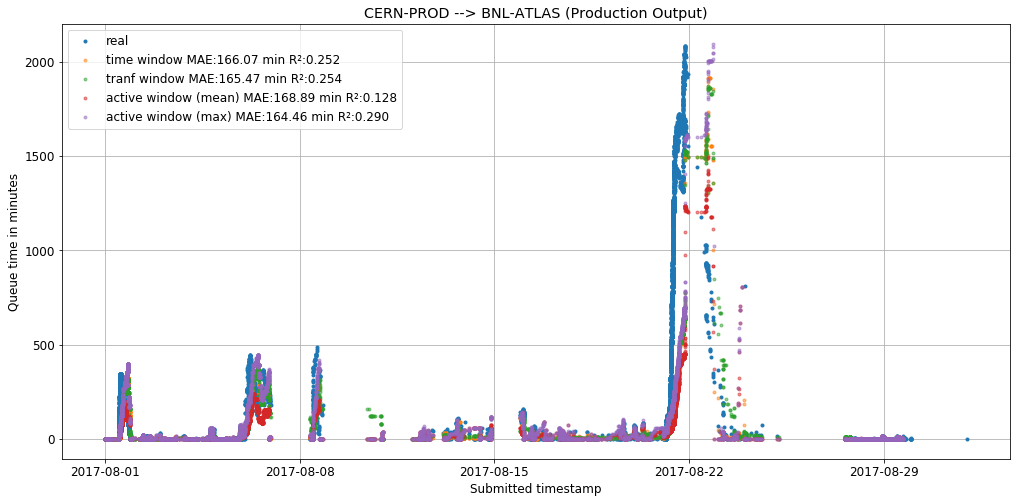

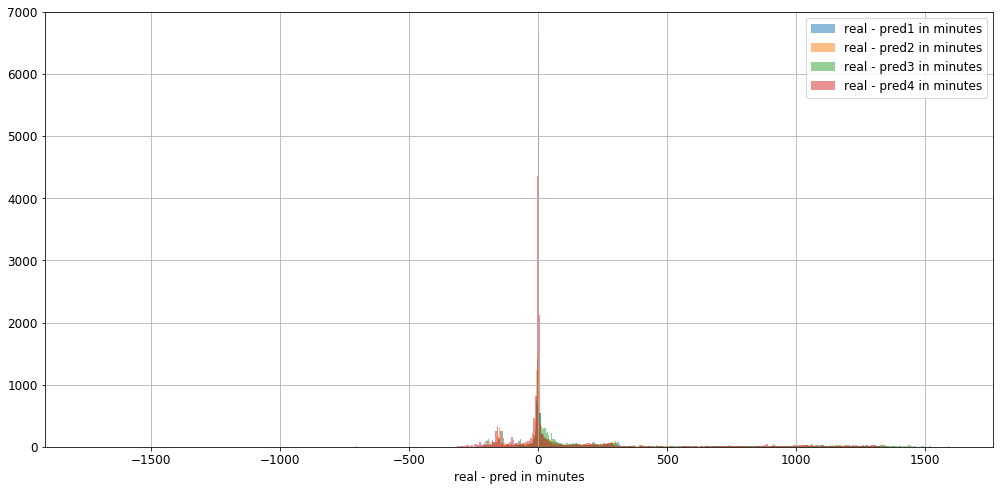

11978 records retrieved for link CERN-PROD --> BNL-ATLAS (Staging).
536.028395897 292.175198783


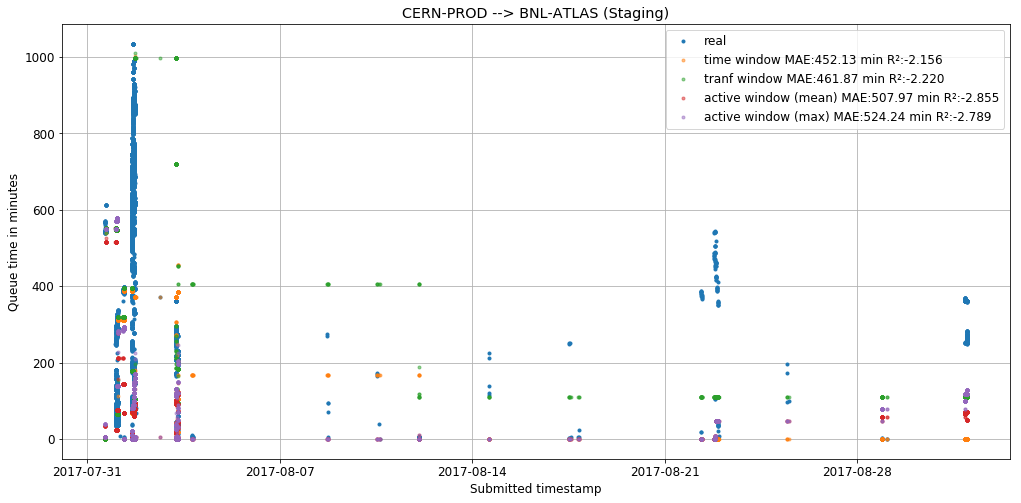

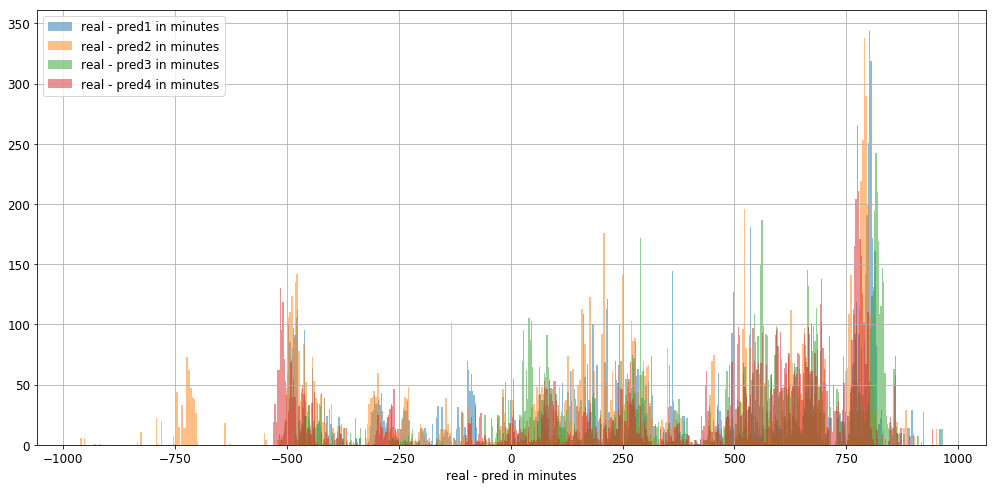

270959 records retrieved for link CERN-PROD --> BNL-ATLAS (T0 Export).
2343.5542443 2694.93240205


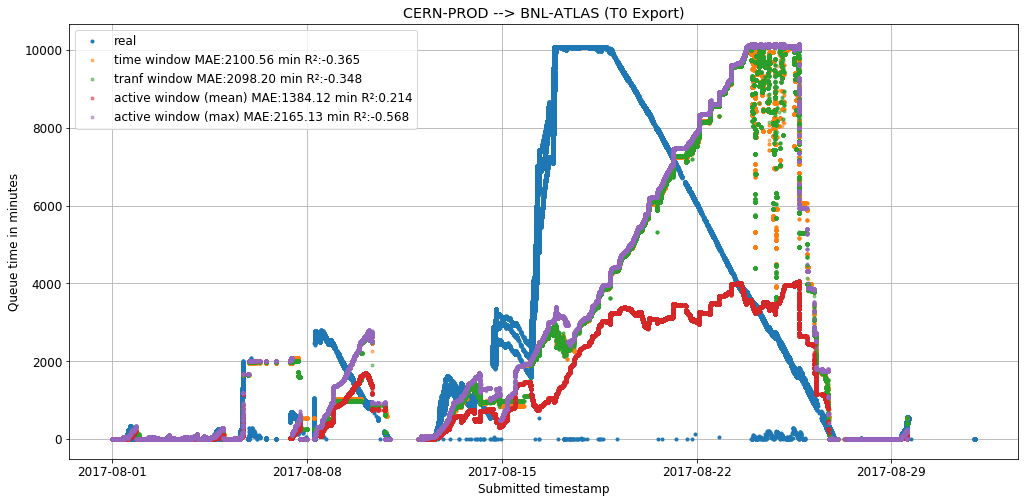

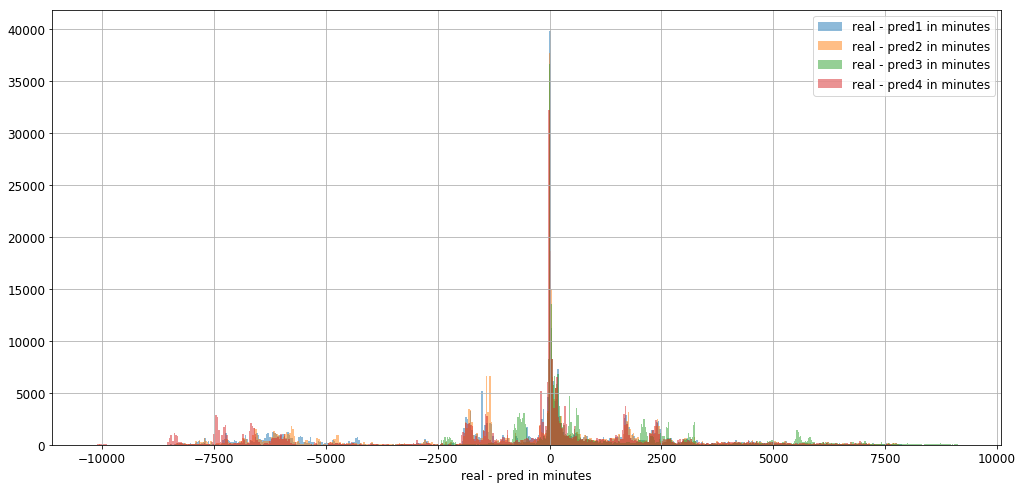

105798 records retrieved for link CERN-PROD --> BNL-ATLAS (User Subscriptions).
1494.26884435 2074.19301442


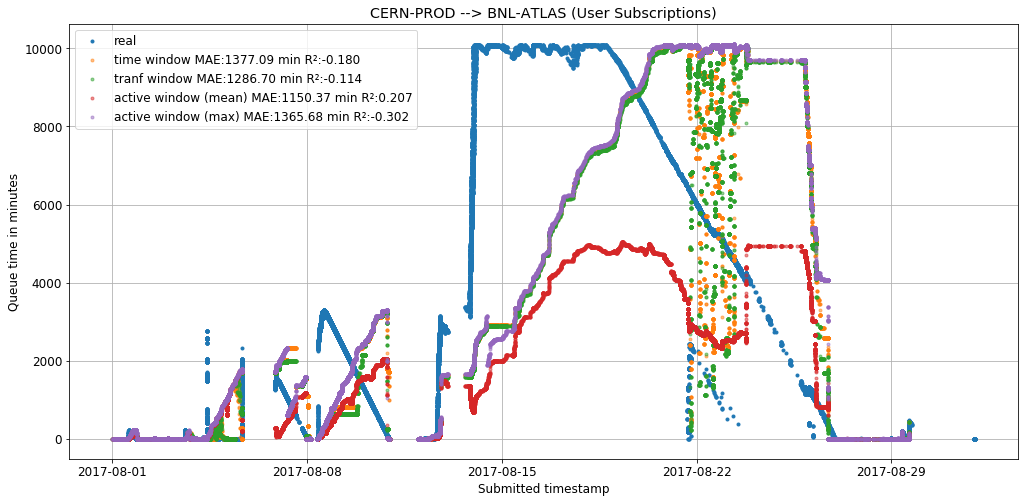

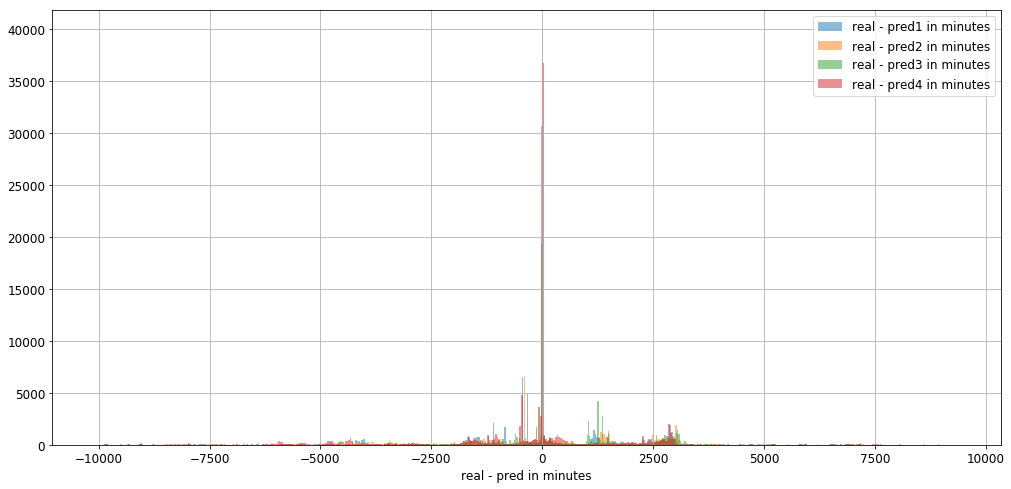

In [47]:
for act in ['Data Consolidation',
            'Functional Test',
            'Express', 
            'Production Input',
            'Production Output',
            'Staging',
            'T0 Export',
            'User Subscriptions'
           ]:
    compare_ewma('CERN-PROD0.05','BNL-ATLAS', act, 31)